# Imports

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import os
import numpy as np

import json

from transformers import MarianTokenizer, AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt
import collections

# Defining plot styles

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, kde, gaussian_kde
import matplotlib
from matplotlib import rc

import pandas as pd

In [3]:


plt.rcParams['font.family'] = 'serif'
#plt.rcParams['text.usetex'] = True
plt.rcParams['text.usetex'] = False
# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Times New Roman']

# plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 26
plt.rcParams['axes.labelsize'] = 26
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['axes.titlesize'] = 26
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 18


# Load / Process data

In [4]:
tokenizer_de = AutoTokenizer.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
tokenizer_he = AutoTokenizer.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

In [5]:
def get_num_of_tokens_per_gender(professions, translations_dict, tokenizer, target_file):
    male_count, male_tokens, female_count, female_tokens = 0, 0, 0, 0
    male_num_of_tokens_map, female_num_of_tokens_map = {}, {}
    for profession in professions:
        m, f = list(translations_dict[profession]['Male']), list(translations_dict[profession]['Female'])


        for mp in m:
            male_count += 1
            male_num_of_tokens = len(tokenizer(mp, add_special_tokens=False)['input_ids'])
            male_tokens += male_num_of_tokens
            if male_num_of_tokens not in male_num_of_tokens_map:
                male_num_of_tokens_map[male_num_of_tokens] = 1
            else:
                male_num_of_tokens_map[male_num_of_tokens] += 1
        for fp in f:
            female_count += 1
            female_num_of_tokens = len(tokenizer(fp, add_special_tokens=False)['input_ids'])
            female_tokens += female_num_of_tokens
            if female_num_of_tokens not in female_num_of_tokens_map:
                female_num_of_tokens_map[female_num_of_tokens] = 1
            else:
                female_num_of_tokens_map[female_num_of_tokens] += 1
    with open(target_file, 'w+') as f:
        f.write("male: " + str(male_tokens / male_count) + "\n")
        f.write("female: " + str(female_tokens / female_count) + "\n")
    max_tokens = max(max(male_num_of_tokens_map.keys()),max(female_num_of_tokens_map.keys()))
    return male_tokens / male_count, female_tokens / female_count, male_num_of_tokens_map, female_num_of_tokens_map, max_tokens

def count_tokens(translations_dict, mp, count,tokenizer, tokens, num_of_tokens_map, gender):
    professions = list(translations_dict[mp][gender])
    count += len(professions)
    for p in professions:
        num_of_tokens = len(tokenizer(p, add_special_tokens=False)['input_ids'])
        tokens += num_of_tokens
        if num_of_tokens not in num_of_tokens_map:
            num_of_tokens_map[num_of_tokens] = 1
        else:
            num_of_tokens_map[num_of_tokens] += 1
    return tokens,count

def get_annotations_dict(merged_annotations):
    translations_dict = {}
    professions = set()
    with open(merged_annotations, 'r') as f:
        lines = f.readlines()
    for line in lines:
        line = line.strip()
        columns = line.split("\t")
        english_profession = columns[0]
        professions.add(english_profession)
        if not english_profession in translations_dict:
            translations_dict[english_profession] = {'Male': [], 'Female': []}
        for i in range(1, len(columns)):
            if columns[i] != "":
                if i % 2 and columns[i]:
                    translations_dict[english_profession]['Male'].append(columns[i])
                else:
                    translations_dict[english_profession]['Female'].append(columns[i])
    return translations_dict, professions

def get_num_of_tokens_per_stereotype(male_stereotype,female_stereotype,translations_dict, tokenizer, target_file):
    stereotype_count, stereotype_tokens, anti_stereotype_count, anti_stereotype_tokens = 0, 0, 0, 0
    stereotype_num_of_tokens_map, anti_stereotype_num_of_tokens_map = {}, {}

    for mp in male_stereotype:
        tokens,count = count_tokens(translations_dict, mp, stereotype_count,tokenizer, stereotype_tokens, stereotype_num_of_tokens_map,'Male')
        stereotype_tokens+=tokens
        stereotype_count+=count
        tokens,count = count_tokens(translations_dict, mp, anti_stereotype_count,tokenizer, anti_stereotype_tokens, anti_stereotype_num_of_tokens_map,'Female')
        anti_stereotype_tokens += tokens
        anti_stereotype_count += count
    for fp in female_stereotype:
        tokens,count = count_tokens(translations_dict, fp, stereotype_count,tokenizer, stereotype_tokens, stereotype_num_of_tokens_map,'Female')
        stereotype_tokens += tokens
        stereotype_count += count
        tokens,count = count_tokens(translations_dict, fp, anti_stereotype_count,tokenizer, anti_stereotype_tokens, anti_stereotype_num_of_tokens_map,'Male')
        anti_stereotype_tokens += tokens
        anti_stereotype_count += count
    with open(target_file, 'w+') as f:
        f.write("stereotype: " + str(stereotype_tokens / stereotype_count) + "\n")
        f.write("anti stereotype: " + str(anti_stereotype_tokens / anti_stereotype_count) + "\n")
    max_tokens = max(max(stereotype_num_of_tokens_map.keys()),max(anti_stereotype_num_of_tokens_map.keys()))
    return stereotype_tokens / stereotype_count, anti_stereotype_tokens / anti_stereotype_count,\
           stereotype_num_of_tokens_map, anti_stereotype_num_of_tokens_map, max_tokens


In [6]:
he_translations, professions = get_annotations_dict("../data/he_merged_translations_new.txt")
de_translations, professions = get_annotations_dict("../data/de_merged_translations_new.txt")
he_male_average_tokens, he_female_average_tokens, he_male_num_of_tokens_map, he_female_num_of_tokens_map, he_max_tokens = \
        get_num_of_tokens_per_gender(professions, he_translations, tokenizer_he, "../data/he_tokens_per_gender_mbart50.txt")
de_male_average_tokens, de_female_average_tokens, de_male_num_of_tokens_map, de_female_num_of_tokens_map, de_max_tokens = \
    get_num_of_tokens_per_gender(professions, de_translations, tokenizer_de, "../data/de_tokens_per_gender_mbart50.txt")

In [7]:
with open("../data/male_stereotype","r") as f:
    male_stereotype = f.readlines()
    male_stereotype = [i.strip() for i in male_stereotype]
with open("../data/female_stereotype","r") as f:
    female_stereotype = f.readlines()
    female_stereotype = [i.strip() for i in female_stereotype]


he_stereotype_avg_tokens, he_anti_stereotype_avg_tokens, \
he_stereotype_num_of_tokens_map, he_anti_stereotype_num_of_tokens_map, he_max_tokens = \
    get_num_of_tokens_per_stereotype(male_stereotype, female_stereotype, he_translations, tokenizer_he, "../data/he_tokens_per_stereotype_mbart50.txt")

de_stereotype_avg_tokens, de_anti_stereotype_avg_tokens, \
de_stereotype_num_of_tokens_map, de_anti_stereotype_num_of_tokens_map, de_max_tokens = \
    get_num_of_tokens_per_stereotype(male_stereotype, female_stereotype, de_translations, tokenizer_de, "../data/de_tokens_per_stereotype_mbart50.txt")

In [8]:
male_stereotype

['construction worker',
 'janitor',
 'laborer',
 'developer',
 'supervisor',
 'cook',
 'manager',
 'carpenter',
 'sheriff',
 'mover',
 'guard',
 'analyst',
 'lawyer',
 'mechanic',
 'physician',
 'CEO',
 'driver',
 'chief',
 'farmer',
 'salesperson']

In [9]:
female_stereotype

['attendant',
 'assistant',
 'editor',
 'secretary',
 'auditor',
 'clerk',
 'baker',
 'housekeeper',
 'cashier',
 'counselor',
 'tailor',
 'teacher',
 'hairdresser',
 'librarian',
 'accountant',
 'nurse',
 'designer',
 'writer',
 'cleaner',
 'receptionist']

In [10]:
he_stereotype_num_of_tokens_map, he_anti_stereotype_num_of_tokens_map

({3: 14, 4: 6, 2: 25, 1: 5, 5: 3}, {4: 9, 5: 1, 3: 15, 2: 20, 1: 8})

# Create Plots

In [11]:
def graphs_3_and_4(group1_num_of_tokens_map, group2_num_of_tokens_map, max_tokens, title, group1_name,group2_name):
    for i in range(1,max_tokens+1):
        if i not in group1_num_of_tokens_map:
            group1_num_of_tokens_map[i] = 0
        if i not in group2_num_of_tokens_map:
            group2_num_of_tokens_map[i] = 0
    group1_num_of_tokens_map = collections.OrderedDict(sorted(group1_num_of_tokens_map.items()))
    group2_num_of_tokens_map = collections.OrderedDict(sorted(group2_num_of_tokens_map.items()))


    
    if 'Gender' in title:
        graph_num = '3'
        data_1 = pd.DataFrame({'tokens' : group1_num_of_tokens_map.keys(),
                              'count': group1_num_of_tokens_map.values(),
                              'gender': ['male'] * len(group1_num_of_tokens_map)})
        data_2 = pd.DataFrame({'tokens' : group2_num_of_tokens_map.keys(),
                              'count': group2_num_of_tokens_map.values(),
                              'gender': ['female'] * len(group2_num_of_tokens_map)})

        data= pd.concat([data_1, data_2])
                                  
        g = sns.catplot(x="tokens", y="count",
                data=data, kind="bar", hue='gender', 
                hue_order = ['male', 'female'],
                palette=sns.color_palette(['lightblue', 'brown']),
                height=4.5, aspect=1.8, legend=False)
        leg_title = 'gender'
        fig = g.fig
        axes = g.axes
        
    else:
        graph_num = '4'
        data_1 = pd.DataFrame({'tokens' : group1_num_of_tokens_map.keys(),
                              'count': group1_num_of_tokens_map.values(),
                              'stereotype': ['pro'] * len(group1_num_of_tokens_map)})
        data_2 = pd.DataFrame({'tokens' : group2_num_of_tokens_map.keys(),
                              'count': group2_num_of_tokens_map.values(),
                              'stereotype': ['anti'] * len(group2_num_of_tokens_map)})

        data = pd.concat([data_1, data_2])
          
        g = sns.catplot(x="tokens", y='count',
                data=data, kind="bar", hue='stereotype', 
                hue_order = ['pro', 'anti'],
                palette=sns.color_palette(['mediumaquamarine', 'darkorange']),
                height=4.5, aspect=1.8, legend=False)
        leg_title = 'stereotype'
        fig = g.fig
        axes = g.axes

        
    axes[0,0].set_xlim(left=-0.5, right=3.5)
    axes[0,0].set_ylim(bottom=0.0, top=40)
        
    if 'Hebrew' in title:
        lang = 'he'
        axes[0,0].legend(ncol=1,loc='lower right', bbox_to_anchor=(.99, 0.4), title=leg_title)
    else:
        lang = 'de'
        
    plt.tight_layout()

    plt.savefig(f'../graphs/graph_{graph_num}_{lang}_mbart.pdf', dpi=300)
    
    plt.show()


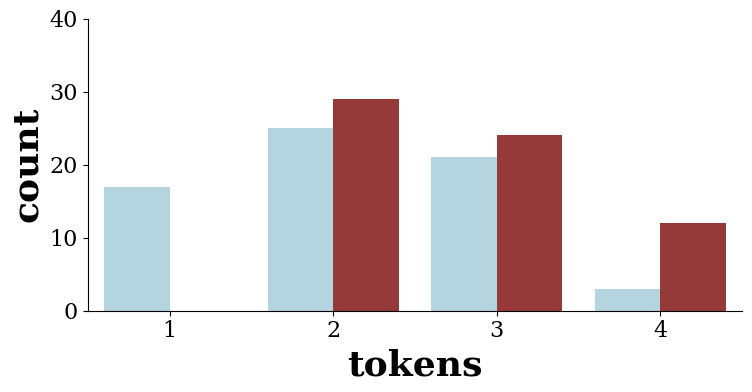

In [12]:
graphs_3_and_4(de_male_num_of_tokens_map, de_female_num_of_tokens_map, de_max_tokens, 
               "German num of tokens per Gender", "Male", "Female")

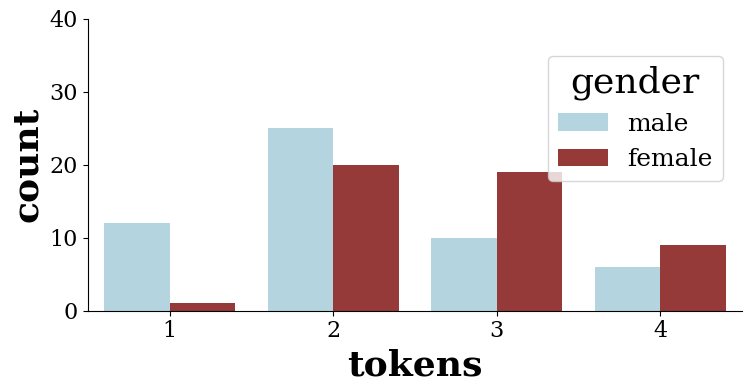

In [13]:
graphs_3_and_4(he_male_num_of_tokens_map, he_female_num_of_tokens_map, he_max_tokens, 
               "Hebrew num of tokens per Gender", "Male", "Female")

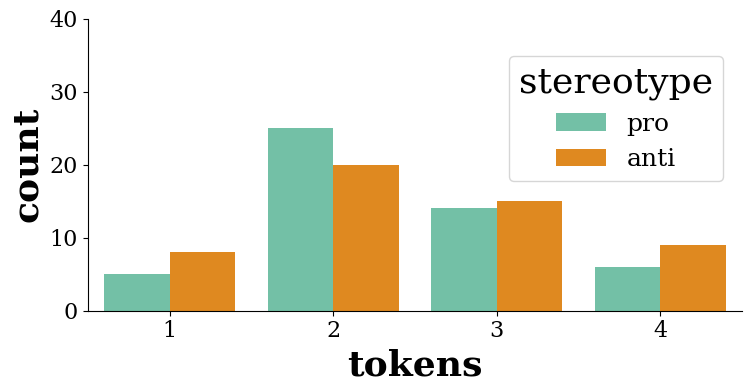

In [14]:
graphs_3_and_4(he_stereotype_num_of_tokens_map, he_anti_stereotype_num_of_tokens_map, he_max_tokens, "Hebrew num of tokens per stereotype", "stereotype", "Anti stereotype")

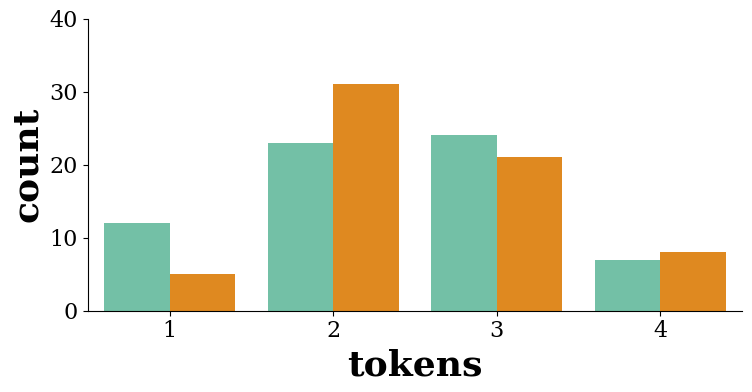

In [15]:
graphs_3_and_4(de_stereotype_num_of_tokens_map, de_anti_stereotype_num_of_tokens_map, de_max_tokens, "German num of tokens per stereotype", "stereotype", "Anti stereotype")